# Modeling M100 Lateness

Here we're trying to model the M100's lateness and simulated crowdedness in the St. Nicholas stop going to Inwood 220 St Via Amsterdam Via Bway. 

We are applying Datacamp's Decision-Tree for Classification

## Table of Contents:
1. [Data Cleaning](#data-cleaning)
1. [Plotting a Chart for Sanity](#plotting-a-chart-for-sanity)
1. [Saving our Progress](#saving-our-progress)
1. [Model Training](#model-training)\*
1. [Data Cleaning](#data-cleaning)\*

\* Not finished yet

Imports

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold, train_test_split

warnings.filterwarnings("ignore")
random_state = 20181112
import datetime, math, glob

Adding data from the M100 csv file.

In [2]:
%%capture
df = pd.read_csv('M100_Aug_W125_st.csv', error_bad_lines=False)

# Choosing the Best Classifier

We want (a) regressor(s) that can predict the **wait time** and **crowding** of a bus at a specific stop with the inputs **hourly weather** and **time of day**. We would most likely have two models that predict each **wait time** and **crowding**.

Here are our top picks for regressors:

1. Gradient Boosting Machines ***(top pick)***:
    - Why: GBMs are typically a composite model that combines the efforts of multiple weak models to create a strong model, and each additional weak model reduces the mean squared error (MSE) of the overall model. Our goal would be to minimize MSE to increase the accuracy of our predictions.

1. Random Forest:
    - Why: does not suffer from the overfitting like with Decision Trees. Instead of randomly choosing to split from just **hourly weather** and **time of day**, we can have two trees that randomly split from each and find the best model. 

1. Decision Trees:  
    - Reduction in Standard Deviation (metric): This is a regression metric that measures how much we’ve reduced our uncertainty by picking a split point. By picking the best split each time the greedy decision tree training algorithm tries to form decisions with as few splits as possible.  
    - Hyperparameters:   
        * Max depth: Limit our tree to a `n` depth to prevent overfitting.
        

Evaluating our model:

Since we're creating regression models, we are interested in the ***mean squared error*** and ***R Squared***. The lower our ***R Squared*** the more accurate our model. We intend to use **K-fold cross validation** as well as a **holdout set** as we improve our model through hyperparameter tuning. 

    * Preventing 

# Data Cleaning

What we need to do:  

1. Clean and break up the time components (Hour, Mins, Secs) of the following:
    * `RecordedAtTime`
    * `ExpectedArrivalTime`
    * `ScheduledArrivalTime`
    
2. Store features of interest:
    * `RecordedAtTime`
    * `VehicleLocation.Longitude`
    * `VehicleLocation.Latitude`
    * `DistanceFromStop`
    * `ExpectedArrivalTime`
   

In [3]:
df['ScheduledArrivalTime'] = pd.to_datetime(df.ScheduledArrivalTime, errors='coerce')
df.dropna()
df['Scheduled_Hour'] = df['ScheduledArrivalTime'].dt.hour
df['Scheduled_Minute'] = df['ScheduledArrivalTime'].dt.minute
df['Scheduled_Seconds'] = df['ScheduledArrivalTime'].dt.second

df['RecordedAtTime'] = pd.to_datetime(df.RecordedAtTime)
df['Recorded_Hour'] = pd.to_datetime(df.RecordedAtTime).dt.hour
df['Recorded_Minute'] = pd.to_datetime(df.RecordedAtTime).dt.minute
df['Recorded_Seconds'] = pd.to_datetime(df.RecordedAtTime).dt.second

df['ExpectedArrivalTime'] = pd.to_datetime(df.ExpectedArrivalTime)
df['Expected_Hour'] = pd.to_datetime(df.ExpectedArrivalTime).dt.hour
df['Expected_Minute'] = pd.to_datetime(df.ExpectedArrivalTime).dt.minute
df['Expected_Seconds'] = pd.to_datetime(df.ExpectedArrivalTime).dt.second

In [4]:
df.dtypes

RecordedAtTime               datetime64[ns]
DirectionRef                          int64
PublishedLineName                    object
OriginName                           object
OriginLat                           float64
OriginLong                          float64
DestinationName                      object
DestinationLat                      float64
DestinationLong                     float64
VehicleRef                           object
VehicleLocation.Latitude            float64
VehicleLocation.Longitude           float64
NextStopPointName                    object
ArrivalProximityText                 object
DistanceFromStop                    float64
ExpectedArrivalTime          datetime64[ns]
ScheduledArrivalTime         datetime64[ns]
time_diff_bus                        object
time_diff_bus_mins                    int64
Scheduled_Hour                      float64
Scheduled_Minute                    float64
Scheduled_Seconds                   float64
Recorded_Hour                   

In [5]:
df.count()

RecordedAtTime               89
DirectionRef                 89
PublishedLineName            89
OriginName                   89
OriginLat                    89
OriginLong                   89
DestinationName              89
DestinationLat               89
DestinationLong              89
VehicleRef                   89
VehicleLocation.Latitude     89
VehicleLocation.Longitude    89
NextStopPointName            89
ArrivalProximityText         89
DistanceFromStop             89
ExpectedArrivalTime          89
ScheduledArrivalTime         86
time_diff_bus                88
time_diff_bus_mins           89
Scheduled_Hour               86
Scheduled_Minute             86
Scheduled_Seconds            86
Recorded_Hour                89
Recorded_Minute              89
Recorded_Seconds             89
Expected_Hour                89
Expected_Minute              89
Expected_Seconds             89
dtype: int64

In [20]:
features = (['VehicleLocation.Longitude', 
             'VehicleLocation.Latitude', 
             'OriginLong',
             'OriginLat',
             'DistanceFromStop',
             'Recorded_Hour',
             'Scheduled_Hour',
             'Scheduled_Minute',
             'Scheduled_Seconds',
             'Recorded_Minute',
             'Recorded_Seconds',
             'time_diff_bus_mins'
            ])

model_df = df[(features)].dropna().reset_index()

model_df.count()

index                        86
VehicleLocation.Longitude    86
VehicleLocation.Latitude     86
OriginLong                   86
OriginLat                    86
DistanceFromStop             86
Recorded_Hour                86
Scheduled_Hour               86
Scheduled_Minute             86
Scheduled_Seconds            86
Recorded_Minute              86
Recorded_Seconds             86
time_diff_bus_mins           86
dtype: int64

# Plotting a Chart for Sanity

We want to have a frequency/histogram for each hour of the day and for each minute of the hour.

Credit: David

In [7]:
def ecdf(inputSeries, label):
    try:
        x = np.sort(inputSeries)
    except:
        print("Warning: Series Unsorted")
        x = inputSeries
    y = np.arange(1, len(x)+1) / len(x)
    _ = plt.plot(x, y, marker='.', linestyle='none')
    _ = plt.xlabel('Time Delta ({})'.format(label))
    _ = plt.ylabel('ECDF')
    plt.margins(0.02) # Keeps data off plot edges
    plt.show()

def hist(inputSeries, label):
    plt.hist(inputSeries, bins=25, density=True)
    _ = plt.xlabel('Time Delta ({})'.format(label))
    _ = plt.ylabel('PDF')
    plt.show()

In [8]:
M100_NICK_Avg = df[['Recorded_Hour','time_diff_bus_mins', 'Recorded_Minute']]
M100_Hour = M100_NICK_Avg.groupby('Recorded_Hour').mean().dropna()
M100_Min = M100_NICK_Avg.groupby('Recorded_Minute').mean().dropna()
M100_NICK_Avg.head()

,Recorded_Hour,time_diff_bus_mins,Recorded_Minute
0,7,0,51
1,7,0,51
2,7,0,51
3,11,191,2
4,13,161,42


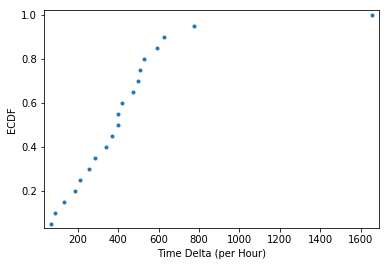

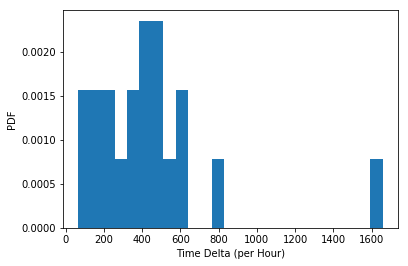

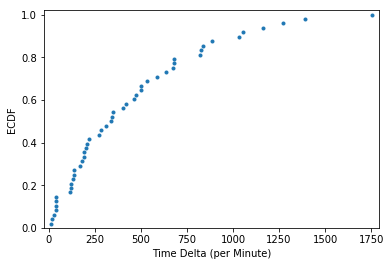

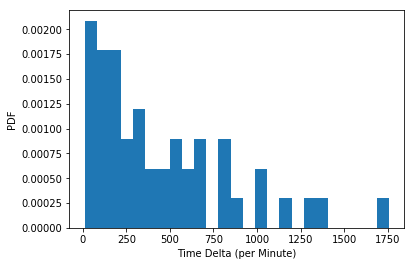

In [9]:
ecdf(M100_Hour['time_diff_bus_mins'], "per Hour")
hist(M100_Hour['time_diff_bus_mins'], "per Hour")

ecdf(M100_Min['time_diff_bus_mins'], "per Minute")
hist(M100_Min['time_diff_bus_mins'], "per Minute")

# Saving our Progress/Merging Weather Data

In [109]:
model_df.to_csv('M100_4_month_W125_st_timesplit.csv', encoding='utf-8', index=False)

NameError: name 'model_df' is not defined

In [2]:
%%capture
weather = pd.read_csv('1401011.csv', error_bad_lines=False)

In [4]:
weather['dates'] = weather['DATE'].str.split(' ', 1, expand=True)

ValueError: Wrong number of items passed 2, placement implies 1

In [111]:
%%capture
df = pd.read_csv('M100_Aug_W125_st.csv', error_bad_lines=False)

Splitting training and testing datasets

In [163]:
newWeather = weather[['DATE','HOURLYVISIBILITY', 'HOURLYWindSpeed', 'HOURLYPrecip']]

In [164]:
newWeather['HOUR'] = pd.to_datetime(weather['DATE']).dt.hour
newWeather['DAY'] = pd.to_datetime(weather['DATE']).dt.dayofweek

In [ ]:
# Time gate to August

newWeather = newWeather[(newWeather['DATE'] > '2017-08-01') & (newWeather['DATE'] < '2017-09-01')].reset_index().dropna()

In [174]:

# Fix some data types
newWeather['HOURLYPrecip'] = pd.to_numeric(newWeather['HOURLYPrecip'], downcast='float', errors='coerce')
newWeather['HOURLYVISIBILITY'] = pd.to_numeric(newWeather['HOURLYVISIBILITY'], downcast='float', errors='coerce')
# Bound hour of day
newWeather = newWeather[(newWeather['HOUR'] > 4) & (newWeather['HOUR'] < 20)]
newWeather

,level_0,index,DATE,HOURLYVISIBILITY,HOURLYWindSpeed,HOURLYPrecip,HOUR,DAY
5,5,114732,2017-08-01 05:51,10.0,0.0,0.00,5,1
6,6,114733,2017-08-01 06:51,10.0,0.0,0.00,6,1
7,7,114734,2017-08-01 07:51,10.0,5.0,0.00,7,1
8,8,114735,2017-08-01 08:51,10.0,6.0,0.00,8,1
9,9,114736,2017-08-01 09:51,10.0,0.0,0.00,9,1
10,10,114737,2017-08-01 10:51,10.0,3.0,0.00,10,1
11,11,114738,2017-08-01 11:51,10.0,5.0,0.00,11,1
12,12,114739,2017-08-01 12:51,10.0,3.0,0.00,12,1
13,13,114740,2017-08-01 13:51,10.0,3.0,0.00,13,1
14,14,114741,2017-08-01 14:51,10.0,0.0,0.00,14,1


In [147]:
newWeather.dtypes

level_0               int64
index                 int64
DATE                 object
HOURLYVISIBILITY    float32
HOURLYWindSpeed     float64
HOURLYPrecip        float32
HOUR                  int64
DAY                   int64
dtype: object

In [176]:
newWeather['HOUR'].value_counts()

8     39
10    37
12    36
6     35
17    34
9     34
7     34
19    33
18    33
14    33
16    32
15    32
13    32
5     32
11    29
Name: HOUR, dtype: int64

# Model Training

Adapted from: https://shankarmsy.github.io/stories/gbrt-sklearn.html

In [6]:
#Importing required Python packages 
%matplotlib inline 
import matplotlib.pylab as plt 
import numpy as np 
from scipy import sparse 
from sklearn.datasets import make_classification, make_blobs, load_boston, fetch_california_housing 
from sklearn.decomposition import PCA 
from sklearn.cross_validation import ShuffleSplit, train_test_split 
from sklearn import metrics 
from sklearn.learning_curve import learning_curve 
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.grid_search import GridSearchCV 
from pprint import pprint 
import pandas as pd 
from pandas.tools.plotting import scatter_matrix 
import urllib 
import requests 
import zipfile 
import seaborn 

np.random.seed(sum(map(ord, "aesthetics"))) 
seaborn.set_context('notebook') 
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier 
plt.rcParams['figure.figsize'] = (15, 5) # Set some Pandas options 
pd.set_option('display.notebook_repr_html', False) 
pd.set_option('display.max_columns', 40) 
pd.set_option('display.max_rows', 25) 
pd.options.display.max_colwidth = 50 


## Features, Targets and Splitting

In [7]:
cal=fetch_california_housing()

In [8]:
# Split data here
X_train, X_test, y_train, y_test = train_test_split(cal.data, cal.target) 

## The Gradient Boosting Regression Tree

In [9]:
gbrt=GradientBoostingRegressor(n_estimators=100) 

gbrt.fit(X_train, y_train) 
y_pred=gbrt.predict(X_test) 

## Designing the model

In [10]:
 def GradientBooster(param_grid, n_jobs): 
        estimator = GradientBoostingRegressor() 
        #Choose cross-validation generator - let's choose ShuffleSplit which randomly shuffles and selects Train and CV sets 
        #for each iteration. There are other methods like the KFold split. 
        cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2) 
        
        #Apply the cross-validation iterator on the Training set using GridSearchCV. This will run the classifier on the 
        #different train/cv splits using parameters specified and return the model that has the best results 
        #Note that we are tuning based on the F1 score 2PR/P+R where P is Precision and R is Recall. This may not always be 
        #the best score to tune our model on. I will explore this area further in a seperate exercise. For now, we'll use F1. 
        
        classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs) 
        #Also note that we're feeding multiple neighbors to the GridSearch to try out. 
        #We'll now fit the training dataset to this classifier 
        classifier.fit(X_train, y_train) 
        
        #Let's look at the best estimator that was found by GridSearchCV 
        print("Best Estimator learned through GridSearch") 
        print(classifier.best_estimator_) 
        return cv, classifier.best_estimator_ 

In [11]:
#Below is a plot_learning_curve module that's provided by scikit-learn. It allows us to quickly and easily visualize how #well the model is performing based on number of samples we're training on. It helps to understand situations such as #high variance or bias. 
#We'll call this module in the next segment. 
print(__doc__) 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn import cross_validation 
from sklearn.naive_bayes import GaussianNB 
from sklearn.datasets import load_digits 
from sklearn.learning_curve import learning_curve 

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)): 
    """ Generate a simple plot of the test and traning learning curve. 
    
    Parameters 
    ---------- 
    estimator : 
    object type that implements the "fit" and "predict" methods An object of that type which is cloned for 
    each validation. title : string Title for the chart. X : array-like, shape (n_samples, n_features) 
    Training vector, where n_samples is the number of samples and n_features is the number of features. 
    y : 
    array-like, shape (n_samples) or (n_samples, n_features), optional Target relative to X for classification 
    or regression; None for unsupervised learning. ylim : tuple, shape (ymin, ymax), optional Defines minimum 
    and maximum yvalues plotted. cv : integer, cross-validation generator, optional If an integer is passed, 
    it is the number of folds (defaults to 3). Specific cross-validation objects can be passed, 
    see sklearn.cross_validation module for the list of possible objects n_jobs : integer, 
    optional Number of jobs to run in parallel (default 1). """ 
    
    plt.figure() 
    plt.title(title) 
    if ylim is not None: 
        plt.ylim(*ylim) 
    plt.xlabel("Training examples") 
    plt.ylabel("Score") 
    train_sizes, train_scores, test_scores = learning_curve( estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes) 
    train_scores_mean = np.mean(train_scores, axis=1) 
    train_scores_std = np.std(train_scores, axis=1) 
    test_scores_mean = np.mean(test_scores, axis=1) 
    test_scores_std = np.std(test_scores, axis=1) 
    plt.grid() 
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r") 
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g") 
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score") 
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score") 
    plt.legend(loc="best") 
    
    return plt 

Automatically created module for IPython interactive environment


In [12]:
#WARNING - THIS MIGHT TAKE A WHILE TO RUN. TRY ADJUSTING parameters such as n_jobs (jobs to run in parallel, before 
#increasing this make sure your system can handle it), n_iter for ShuffleSplit (in the function definition) and reducing 
#number of values being tried for max_depth/n_estimators. 
#SELECT INTERRUPT IN THE MENU AND PRESS INTERRUPT KERNEL IF YOU NEEDD TO STOP EXECUTION 

param_grid={
    'n_estimators':[100], 
    'learning_rate': [0.1],# 0.05, 0.02, 0.01], 
    'max_depth':[6],#4,6], 
    'min_samples_leaf':[3],#,5,9,17], 
    'max_features':[1.0],#,0.3]#,0.1] 
} 

n_jobs=4 
#Let's fit GBRT to the digits training dataset by calling the function we just created. 

cv,best_est=GradientBooster(param_grid, n_jobs) 

Best Estimator learned through GridSearch
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=1.0,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


In [13]:
#OK great, so we got back the best estimator parameters as follows:
print("Best Estimator Parameters")
print("---------------------------")
print("n_estimators:", best_est.n_estimators)
print("max_depth:", best_est.max_depth)
print("Learning Rate:", best_est.learning_rate)
print("min_samples_leaf:", best_est.min_samples_leaf)
print("max_features:", best_est.max_features)

print("Train R-squared:", best_est.score(X_train,y_train))

#Each of these parameters is critical to learning. Some of them will help address overfitting issues as well. For more 
#info about overfitting and regularization, check out the SVM notebook in my Github repos where I provide more info on 
#the subject.


Best Estimator Parameters
---------------------------
n_estimators: 100
max_depth: 6
Learning Rate: 0.1
min_samples_leaf: 3
max_features: 1.0
Train R-squared: 0.9033749663


In [ ]:
#The module simply runs the estimator multiple times on subsets of the data provided and plots the train and cv scores.
#Note that we're feeding the best parameters we've learned from GridSearchCV to the estimator now.
#We may need to adjust the hyperparameters further if there is overfitting (or underfitting, though unlikely)
title = "Learning Curves (Gradient Boosted Regression Trees)" 
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
                                      learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
                                      max_features=best_est.max_features)
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
plt.show()

#Looks like we've done a reasonable job getting about ~0.85 R-squared on the cv set and looks from the learning
#curve that we may be able to do a bit better with more estimators. Although we may need to reduce the learning rate even 
#further to address any overfitting.

In [ ]:
#Let's try one more trick. We'll trim the training set to its most important features and re-train to see if 
#that helps.
title = "Learning Curves (Gradient Boosted Regression Trees)" 

#Dropping all parameters except n_estimators and learning_rate since we're going to trim the features anyway.
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, learning_rate=best_est.learning_rate)

#Calling fit on the estimator so we can transform the X matrices.
estimator.fit(X_train, y_train)

#Trimming feature matrices to include only those features that are more important than the mean of all importances.
X_train_trim=estimator.transform(X_train, threshold='mean')

#Trimming test as well in case we end up going with this model as final.
X_test_trim=estimator.transform(X_test, threshold='mean')

#Re-plotting Learning cruves.
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
plt.show()

#So what do we infer from this plot? We seem to have addressed overfitting much better but the overall score of both train
#and cv has gone down considerably, indicating that the features we dropped were actually collectively contributing
#to the model. Let's go back to the first model that the Grid Search returned and run our test scores.


In [ ]:
#Switching back to the best model from gridsearch
estimator = best_est

#Re-fitting to the train set
estimator.fit(X_train, y_train)

#Calculating train/test scores - R-squared value
print("Train R-squared: ", estimator.score(X_train, y_train))
print("Test R-squared: ", estimator.score(X_test, y_test))

#There you have it, our final R-squared on the California housing dataset, 0.82

In [ ]:
#OK let's run through a more complex example this time. We'll explore anonymous loan data provided by lendingclub. 
#We'll try to predict the interest rate for loan applications based on data provided. Let's first download data to 
#a pandas df.

#The Dataset is a zip file. So let's first read in the dataset through requests then pass it on to Pandas through the
#read_csv command
url=requests.get('https://resources.lendingclub.com/LoanStats3c.csv.zip')
z=zipfile.ZipFile(StringIO.StringIO(url.content))

loan=pd.read_csv(z.open('LoanStats3c.csv'), skiprows=1, parse_dates=True, index_col='id')
loanbk=loan.copy() #Backup of the dataframe so we don't have to download data everytime

In [ ]:
#Let's take a quick peek at the dataset
loan.describe()

In [ ]:
#For simplicity, let's first drop nulls in the dataset. axis=1 indicates we'll drop rows not cols.
loan = loan.dropna(axis=0)

In [ ]:
#OK let's take a look at the columns and see if there are any we can drop any before we get started.
loan.columns.values

#There're plenty that don't seem very relevant. Let's drop them.
loan=loan.drop(['member_id', 'grade', 'sub_grade', 'emp_title', 'issue_d',
          'pymnt_plan', 'url', 'desc', 'title', 'initial_list_status',
          'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
          'policy_code', 'emp_length', 'addr_state','zip_code'], axis=1)

#Check the data dictionary for this dataset at https://resources.lendingclub.com/LCDataDictionary.xlsx for more details

In [ ]:
# Get rid of non-numeric values throughout the DataFrame:
for col in loan.columns.values:
  loan[col] = loan[col].replace('[^0-9]+.-', '', regex=True)
loan.head(2)

In [ ]:
#Remove % symbol from the interest rate & revolving utilization
loan.int_rate=loan.int_rate.str.split('%',1).str[0]
loan.revol_util=loan.revol_util.str.split('%',1).str[0]

#Remove "months" from the loan period
loan.term=loan.term.str.split(' ',2).str[1]

loan.head(2)

In [ ]:
#Let's change the Income Verified column, which currently has textual labels to numeric.
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
loan.is_inc_v = le.fit_transform(loan.is_inc_v.values)
loan.home_ownership=le.fit_transform(loan.home_ownership.values)
loan.loan_status=le.fit_transform(loan.loan_status.values)
loan.purpose=le.fit_transform(loan.purpose.values)

#Finally let's be sure we convert all fields to numeric
loan=loan.convert_objects(convert_numeric=True)

loan.head(2)

In [ ]:
#OK great, let's now get our X and y. We know that interest rate is y.
#Pandas is fantastic, all you need to do is use .values to get the data in numpy format
y=loan.int_rate.values

#Let's remove y from the df so we can get X
del loan['int_rate']
X=loan.values

#Now, the train test split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
#Great, in no time we have grabbed an unknown dataset from the web, munged it using Pandas and now have ready-to-go
#training and test numpy arrays for running the GBRT regressor. Let's go!

#WARNING - THIS MIGHT TAKE A WHILE TO RUN. TRY ADJUSTING parameters such as n_jobs (jobs to run in parallel, before 
#increasing this make sure your system can handle it), n_iter for ShuffleSplit (in the function definition) and reducing 
#number of values being tried for max_depth/n_estimators.

#SELECT INTERRUPT IN THE MENU AND PRESS INTERRUPT KERNEL IF YOU NEEDD TO STOP EXECUTION

param_grid={'n_estimators':[100],#,500,1000],
            'learning_rate': [0.1,0.05,0.02],# 0.01],
            'max_depth':[4,6], 
            'min_samples_leaf':[3,5,9,17], 
            'max_features':[1.0,0.3,0.1]
           }
n_jobs=4

#Let's fit GBRT to the digits training dataset by calling the function we just created.
cv,best_est=GradientBooster(param_grid, n_jobs)

In [ ]:
#OK great, so we got back the best estimator parameters as follows:
print("Best Estimator Parameters")
print("---------------------------")
print ("n_estimators:", best_est.n_estimators)
print ("max_depth:", best_est.max_depth)
print ("Learning Rate:", best_est.learning_rate)
print ("min_samples_leaf:", best_est.min_samples_leaf)
print ("max_features:", best_est.max_features)

print ("Train R-squared:", best_est.score(X_train,y_train))

#The training R-Squared is almost 1.0 which indicates we can understand 99% of the variance in the data as well as
#there's a chance we might overfit. Let's see with the learning curves below.


In [ ]:
#OK we'll now call the plot_learning_curve module by feeding it the estimator (best estimator returned from GS) 
#and train/cv sets.

#The module simply runs the estimator multiple times on subsets of the data provided and plots the train and cv scores.
#Note that we're feeding the best parameters we've learned from GridSearchCV to the estimator now.
#We may need to adjust the hyperparameters further if there is overfitting (or underfitting, though unlikely)
title = "Learning Curves (Gradient Boosted Regression Trees)" 
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
                                      learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
                                      max_features=best_est.max_features)
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
plt.show()

#OK yes, there is some overfitting there. We can see the training scores in red almost close to 1.0 and the cv scores
#trying its best to reach it as the number of examples increases. This is what happens during overfitting. To address
#overfitting, GBRT basically has the following parameters we can fine tune: Learning Rate, Max Depth, Min Samples leaf and
#Max features.

In [ ]:
#the typical recommended values of Max depth is 4 to 6, so lets leave it at 4. Let's try increasing the min
#samples leaf parameter, this basically enforces a lower bound on the number of samples in any given leaf.
min_samples_leaf=9

title = "Learning Curves (Gradient Boosted Regression Trees), min_samples_leaf=9" 
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
                                      learning_rate=best_est.learning_rate, min_samples_leaf=min_samples_leaf,
                                      max_features=best_est.max_features)
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
plt.show()

In [ ]:
#Let's try reducing the max features parameter. This enforces an upper bound of the maximum number of features to use
#for training. It's supposed to work well when n_features>30. We'll also remove min samples leaf for this run.
max_features=0.5

title = "Learning Curves (Gradient Boosted Regression Trees), max_features=50%" 
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
                                      learning_rate=best_est.learning_rate, max_features=max_features)
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
plt.show()

#Nope that didn't quite improve the cv score either. What happens if we reduce learning rate?

In [ ]:
#The lower the learning rate is the more the number of trees we need to train. This is because the rate at which we train
#is simply, well, reduced.
learning_rate=.01
n_estimators=1000

title = "Learning Curves (Gradient Boosted Regression Trees), 1000 Trees at learning rate .01"
estimator = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=best_est.max_depth,
                                      learning_rate=learning_rate, min_samples_leaf=best_est.min_samples_leaf,
                                      max_features=best_est.max_features)
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
plt.show()

#Perhaps that improved it a tiny little bit.

In [ ]:
#Before we try anything else, I would like to explore one of the beautiful advantages of growing trees. And that is to
#capture feature importances. Now that we have a publicly available loan application collection (though anonymous), it makes
#me really curious to see what impacts the interest rate for a loan application the most.

#Let's take a look

#Calling fit on the estimator so we can look at feature_importances.
estimator.fit(X_train, y_train)

# Calculate the feature ranking - Top 10
importances = estimator.feature_importances_
indices = np.argsort(importances)[::-1]

print "Lending Club Loan Data - Top 10 Important Features\n"

for f in range(10):
    print("%d. %s   (%f)" % (f + 1, loan.columns[indices[f]], importances[indices[f]]))
    
#Plot the feature importances of the forest
indices=indices[:10]
plt.figure()
plt.title("Top 10 Feature importances")
plt.bar(range(10), importances[indices],
       color="r", align="center")
plt.xticks(range(10), loan.columns[indices], fontsize=14, rotation=45)
plt.xlim([-1, 10])
plt.show()

#Mean Feature Importance
print "Mean Feature Importance %.6f" %np.mean(importances)

#Interesting, the total amount of interest received to date is the top most influencer for getting a better interest rate.
#Good for the lenders eh? Pay more interest, we'll give you a cut on the interest rate. Of course!

In [ ]:
#Can we actually trim (like before) and get a better result? Perhaps not, but who's to stop us from trying.
title = "Learning Curves (Gradient Boosted Regression Trees) - Trimmed features to > 1% importance" 

#Dropping all parameters except n_estimators and learning_rate since we're going to trim the features anyway.
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, learning_rate=best_est.learning_rate)

#Calling fit on the estimator so we can transform the X matrices.
estimator.fit(X_train, y_train)

#Trimming feature matrices to include only those features that are more important than the mean of all importances.
X_train_trim=estimator.transform(X_train, threshold=.01)

#Trimming test as well in case we end up going with this model as final.
X_test_trim=estimator.transform(X_test, threshold=.01)

#Re-plotting Learning cruves.
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
plt.show()

#Nope, the curve looks like it overfits less, but look at the cv score, in all our fancy attempts it never really crossed
#that ~0.8 R-squared barrier. That tells me, we actually have a decent model at hand and also that a 0.9+ R-squared value is
#not always possible, atleast in real time. Let's wrap this up.